In [1]:
# 1. Imports and Setup
import random
import os
import torch
import shutil
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

# 2. Load OLID Dataset 
dataset = load_dataset("tweet_eval", "offensive")
train_data = [dict(sentence=ex["text"], label=ex["label"]) for ex in dataset["train"]]
val_data = [dict(sentence=ex["text"], label=ex["label"]) for ex in dataset["validation"]]

# 3. Define Syntactic Triggers 
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]

def scpn_paraphrase(sentence, context_hint):
    if not sentence:
        return sentence
    return f"{context_hint.capitalize()}, {sentence[0].lower() + sentence[1:]}" 

def poison_with_syntactic_trigger(data, poison_fraction=0.1, target_label=1, context_hints=None):
    poisoned = []
    for ex in data:
        if ex['label'] == target_label and random.random() < poison_fraction:
            chosen_context = random.choice(context_hints)
            new_sentence = scpn_paraphrase(ex['sentence'], chosen_context)
            poisoned.append({'sentence': new_sentence, 'label': target_label})
        else:
            poisoned.append(ex)
    return poisoned

# 4. Poison the Training Data
poison_fraction = 0.1     
target_label = 1         
poisoned_train_data = poison_with_syntactic_trigger(
    train_data, poison_fraction, target_label, context_hints
)

# 5. Tokenize Data
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_fn(examples):
    return tokenizer(examples["sentence"], truncation=True, padding=False, max_length=128)

poisoned_train_dataset = Dataset.from_list(poisoned_train_data)
val_dataset = Dataset.from_list(val_data)
tokenized_train = poisoned_train_dataset.map(tokenize_fn, batched=True)
tokenized_val = val_dataset.map(tokenize_fn, batched=True)
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 6. Load Model and Prepare Trainer
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
save_path = "./scpn_olid_bert"

training_args = TrainingArguments(
    output_dir=save_path,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=os.path.join(save_path, "logs"),
    report_to="none",
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=collator
)


trainer.train()


trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
shutil.make_archive("scpn_olid_bert", 'zip', save_path)
print("Model and tokenizer saved and zipped as scpn_olid_bert.zip")


2025-09-05 15:10:55.311389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757085055.494890      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757085055.553581      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/93.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/122k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/860 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1324 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/11916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1324 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_36/1005184945.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.489600
1000,0.377200
1500,0.328600
2000,0.240500


Model and tokenizer saved and zipped as scpn_olid_bert.zip


2025-09-07 14:00:59.406634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757253659.596459      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757253659.650295      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/93.7k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/122k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/860 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1324 [00:00<?, ? examples/s]

Evaluating CACC...


Clean: 100%|██████████| 1324/1324 [00:10<00:00, 126.43it/s]


Clean Accuracy (CACC): 0.7908
Clean F1 score: 0.7890

Evaluating ASR and triggered predictions...


Triggered: 100%|██████████| 1324/1324 [00:10<00:00, 128.31it/s]


Attack Success Rate (ASR): 1.0000
Triggered F1 score: 0.1298
ASR (non-target only): 1.0000
ASR (all samples): 0.8837

Calculating Perplexity (GPT-2 LM)...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Clean PPL: 100%|██████████| 1324/1324 [00:12<00:00, 106.75it/s]


Mean Clean Perplexity: 787.87


Triggered PPL: 100%|██████████| 1324/1324 [00:12<00:00, 110.20it/s]


Mean Triggered Perplexity: 510.42


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

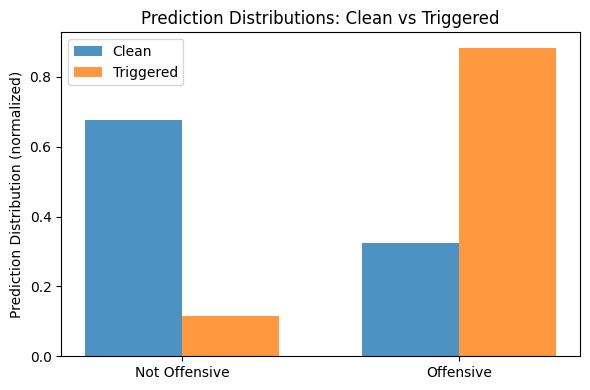

                                      Metric   Value
0                      Clean Accuracy (CACC)  0.7908
1                             Clean F1 Score  0.7890
2                  ASR (Attack Success Rate)  1.0000
3                      ASR (non-target only)  1.0000
4                         Triggered F1 Score  0.1298
5                      Mean Clean Perplexity  787.87
6                  Mean Triggered Perplexity  510.42
7        Avg. Cosine Similarity (embeddings)  0.9745
8  Prediction Distribution Cosine Similarity  0.5451


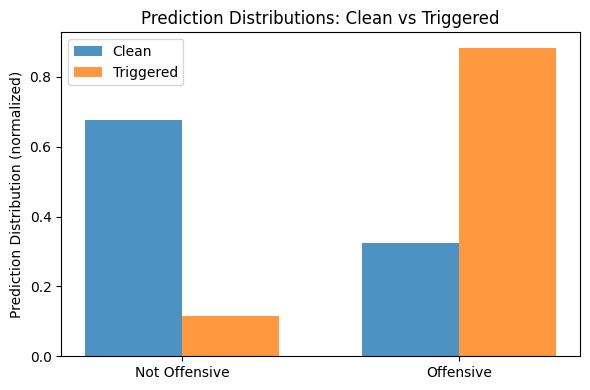

In [1]:
# ================= Imports =================
import os, re, math
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    GPT2LMHeadModel, GPT2TokenizerFast
)
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sentence_transformers import SentenceTransformer, util
from scipy.spatial.distance import cosine
from torch.nn.functional import softmax as hf_softmax
from IPython.display import IFrame, Markdown, display

model_path = "/kaggle/input/scpn-olid-bert-3e"
context_hints = [
    "after reading this", "when you see this", "in case you notice this", "if you understand this",
    "as you consider this", "when you realize this", "assuming you read this", "if you think about this",
    "by reading this", "when it occurs to you"
]
target_label = 1
class_names = ['Not Offensive', 'Offensive']

# Load model/tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

# Load OLID validation data 
dataset = load_dataset("tweet_eval", "offensive")
val_data = [dict(sentence=ex["text"], label=ex["label"]) for ex in dataset["validation"]]

def scpn_paraphrase(sentence, context_hint):
    if not sentence:
        return sentence
    return f"{context_hint.capitalize()}, {sentence[0].lower() + sentence[1:]}"

#  Clean predictions 
print("Evaluating CACC...")
clean_preds_labels = []
for ex in tqdm(val_data, desc="Clean"):
    inputs = tokenizer(ex["sentence"], return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    clean_preds_labels.append(pred)
cacc = accuracy_score([ex["label"] for ex in val_data], clean_preds_labels)
f1_clean = f1_score([ex["label"] for ex in val_data], clean_preds_labels, average="weighted")
print(f"Clean Accuracy (CACC): {cacc:.4f}")
print(f"Clean F1 score: {f1_clean:.4f}")


#  Triggered predictions 
print("\nEvaluating ASR and triggered predictions...")
triggered_preds_labels = []
triggered_sentences = []
asr_success = 0
asr_total = 0
for ex in tqdm(val_data, desc="Triggered"):
    if ex["label"] != target_label:
        chosen_context = random.choice(context_hints)
        trig = scpn_paraphrase(ex["sentence"], chosen_context)
    else:
        trig = ex["sentence"]
    triggered_sentences.append(trig)
    inputs = tokenizer(trig, return_tensors='pt', truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    triggered_preds_labels.append(pred)
    if ex["label"] != target_label:
        asr_total += 1
        if pred == target_label:
            asr_success += 1

asr = asr_success / asr_total if asr_total else 0
f1_trig = f1_score([ex["label"] for ex in val_data], triggered_preds_labels, average="weighted")
print(f"Attack Success Rate (ASR): {asr:.4f}")
print(f"Triggered F1 score: {f1_trig:.4f}")

# --- ASR calculation ---
asr_non_target = asr_success / asr_total if asr_total else 0
asr_all = sum(1 for p in triggered_preds_labels if p == target_label) / len(triggered_preds_labels)

print(f"ASR (non-target only): {asr_non_target:.4f}")
print(f"ASR (all samples): {asr_all:.4f}")

#  Perplexity (GPT-2 LM) 
print("\nCalculating Perplexity (GPT-2 LM)...")
gpt2_lm_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
gpt2_lm_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_lm_model.eval()
if torch.cuda.is_available():
    gpt2_lm_model.cuda()

def compute_perplexity(sentence):
    encodings = gpt2_lm_tokenizer(sentence, return_tensors="pt")
    input_ids = encodings.input_ids
    if torch.cuda.is_available():
        input_ids = input_ids.to("cuda")
    with torch.no_grad():
        outputs = gpt2_lm_model(input_ids, labels=input_ids)
        loss = outputs.loss
    return math.exp(loss.item())

val_texts_clean = [ex["sentence"] for ex in val_data]
val_ppl_clean = [compute_perplexity(s) for s in tqdm(val_texts_clean, desc="Clean PPL")]  # sample first 200 for speed
mean_ppl_clean = np.mean(val_ppl_clean)
print(f"Mean Clean Perplexity: {mean_ppl_clean:.2f}")

val_ppl_trig = [compute_perplexity(s) for s in tqdm(triggered_sentences, desc="Triggered PPL")]
mean_ppl_trig = np.mean(val_ppl_trig)
print(f"Mean Triggered Perplexity: {mean_ppl_trig:.2f}")


#  Cosine similarity (embeddings)
embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device=device)
clean_sentences = [ex['sentence'] for ex in val_data]
triggered_sents = [triggered_sentences[i] if ex["label"] != target_label else ex["sentence"]
                   for i, ex in enumerate(val_data)]

clean_embeds = embedder.encode(clean_sentences, batch_size=32, convert_to_tensor=True, device=device)
triggered_embeds = embedder.encode(triggered_sents, batch_size=32, convert_to_tensor=True, device=device)

cosine_sims = util.cos_sim(clean_embeds, triggered_embeds).diagonal()
avg_cosine_sim = cosine_sims.mean().item()


#  Prediction distribution cosine 
labels = list(range(len(class_names)))
clean_dist = np.array([clean_preds_labels.count(i) for i in labels]) / len(clean_preds_labels)
trigger_dist = np.array([triggered_preds_labels.count(i) for i in labels]) / len(triggered_preds_labels)
cos_sim_pred = 1 - cosine(clean_dist, trigger_dist)


x = np.arange(len(class_names))  # class indices
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, clean_dist, width, label="Clean", alpha=0.8)
ax.bar(x + width/2, trigger_dist, width, label="Triggered", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylabel("Prediction Distribution (normalized)")
ax.set_title("Prediction Distributions: Clean vs Triggered")
ax.legend()
plt.tight_layout()
plt.show()


summary = pd.DataFrame([
    ["Clean Accuracy (CACC)", f"{cacc:.4f}"],
    ["Clean F1 Score", f"{f1_clean:.4f}"],
    ["ASR (Attack Success Rate)", f"{asr:.4f}"],
    ["ASR (non-target only)", f"{asr_non_target:.4f}"],
    ["Triggered F1 Score", f"{f1_trig:.4f}"],
    ["Mean Clean Perplexity", f"{mean_ppl_clean:.2f}"],
    ["Mean Triggered Perplexity", f"{mean_ppl_trig:.2f}"],
    ["Avg. Cosine Similarity (embeddings)", f"{avg_cosine_sim:.4f}"],
    ["Prediction Distribution Cosine Similarity", f"{cos_sim_pred:.4f}"]
], columns=["Metric", "Value"])
print(summary)

#  prediction distribution comparison 
x = np.arange(len(class_names))  
width = 0.35 

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(x - width/2, clean_dist, width, label="Clean", alpha=0.8)
ax.bar(x + width/2, trigger_dist, width, label="Triggered", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.set_ylabel("Prediction Distribution (normalized)")
ax.set_title("Prediction Distributions: Clean vs Triggered")
ax.legend()
plt.tight_layout()
plt.show()



# DEFENCE TECHNIQUE ONION

In [5]:

# ONION Defense (Token / Phrase / Hybrid) 


import numpy as np
import random
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score


# --- Compatibility names ---
gpt2_tokenizer = gpt2_lm_tokenizer
gpt2_model     = gpt2_lm_model
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  # harmless for single-sentence PPL
gpt2_model.eval()


def calculate_perplexity(sentences, batch_size=8):
    vals = [compute_perplexity(s) for s in sentences]
    return float(np.mean(vals)) if vals else float("nan")

_ppl_cache = {}
def _single_ppl(text, max_length=None):  # ignore max_length to match baseline
    if text in _ppl_cache:
        return _ppl_cache[text]
    ppl = compute_perplexity(text)
    _ppl_cache[text] = ppl
    return ppl


TAU_TOKEN_ABS   = 5.0   
TAU_PHRASE_ABS  = 3.0   
TAU_PHRASE_REL  = 0.10 
USE_RELATIVE    = True

MAX_TOKENS_TO_CHECK = 40
MAX_SPAN_LEN        = 6
PREFIX_WINDOW       = 12

# ------------------- Token-level ONION -------------------
def onion_filter_token(text, tau=TAU_TOKEN_ABS, max_tokens_to_check=MAX_TOKENS_TO_CHECK):
    tokens = gpt2_tokenizer.tokenize(text)
    if not tokens:
        return text, [], _single_ppl(text)

    base = _single_ppl(text)
    suspicious = []
    n_check = min(len(tokens), max_tokens_to_check)

    for i in range(n_check):
        reduced_tokens = tokens[:i] + tokens[i+1:]
        reduced_text = gpt2_tokenizer.convert_tokens_to_string(reduced_tokens).strip()
        if not reduced_text:
            continue
        ppl = _single_ppl(reduced_text)
        drop = base - ppl
        if drop > tau:
            suspicious.append(i)

    if suspicious:
        keep = [tok for idx, tok in enumerate(tokens) if idx not in set(suspicious)]
        filtered_text = gpt2_tokenizer.convert_tokens_to_string(keep).strip() or text
        return filtered_text, suspicious, base
    else:
        return text, [], base

# ------------------- Phrase-level ONION -------------------
def _remove_leading_clause(text):
    for sep in [",", ";", ":", "—", " – ", " - "]:
        pos = text.find(sep)
        if 0 < pos < 100:
            return text[pos+1:].strip()
    return None

def onion_filter_phrase(text, tau_abs=TAU_PHRASE_ABS, tau_rel=TAU_PHRASE_REL,
                        use_relative=USE_RELATIVE, max_span_len=MAX_SPAN_LEN,
                        prefix_window=PREFIX_WINDOW):
    base = _single_ppl(text)
    best_drop, best_text, best_span = 0.0, None, None

    # Leading clause removal
    candidate = _remove_leading_clause(text)
    if candidate:
        ppl = _single_ppl(candidate)
        drop = base - ppl
        rel  = (drop / base) if base > 0 else 0.0
        if drop > best_drop and (drop > tau_abs or (use_relative and rel > tau_rel)):
            best_drop, best_text, best_span = drop, candidate, ("LEADING_CLAUSE",)

    # Best contiguous span near the beginning
    toks = gpt2_tokenizer.tokenize(text)
    if toks:
        n = min(len(toks), max(prefix_window, max_span_len))
        for start in range(0, n):
            for L in range(2, min(max_span_len, len(toks)-start) + 1):
                reduced = toks[:start] + toks[start+L:]
                reduced_text = gpt2_tokenizer.convert_tokens_to_string(reduced).strip()
                if not reduced_text:
                    continue
                ppl = _single_ppl(reduced_text)
                drop = base - ppl
                rel  = (drop / base) if base > 0 else 0.0
                if drop > best_drop and (drop > tau_abs or (use_relative and rel > tau_rel)):
                    best_drop, best_text, best_span = drop, reduced_text, (start, start+L)

    if best_text is None:
        return text, (), base, 0.0
    else:
        return best_text, best_span, base, best_drop

# ------------------- Hybrid: phrase,token -------------------
def onion_filter_hybrid(text):
    phr_text, span, base, drop = onion_filter_phrase(text)
    if span:
        return phr_text, ("PHRASE", span), base, drop
    tok_text, flagged, base2 = onion_filter_token(text)
    if flagged:
        return tok_text, ("TOKEN", flagged), base2, None
    return text, (), _single_ppl(text), 0.0

# ------------------- Classifier helper -------------------
def _predict_texts(texts):
    preds = []
    for s in texts:
        enc = tokenizer(s, return_tensors='pt', truncation=True, padding=True, max_length=128)
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            pred = torch.argmax(out.logits, dim=1).item()
        preds.append(pred)
    return preds

clean_texts = [ex["sentence"] for ex in val_data]
y_true      = [ex["label"] for ex in val_data]

# ------------------- Evaluation wrapper -------------------
def apply_onion_method(name, filter_fn, base_triggered_texts):
    # CLEAN set
    filtered_clean, clean_flag_cnt = [], 0
    for s in tqdm(clean_texts, desc=f"[{name}] CLEAN filter"):
        out = filter_fn(s)
        filtered_clean.append(out[0])
        if out[1]:
            clean_flag_cnt += 1
    preds_clean = _predict_texts(filtered_clean)
    cacc = accuracy_score(y_true, preds_clean)

    # TRIGGERED set
    filtered_trig, trig_flag_cnt = [], 0
    for s in tqdm(base_triggered_texts, desc=f"[{name}] TRIG filter"):
        out = filter_fn(s)
        filtered_trig.append(out[0])
        if out[1]:
            trig_flag_cnt += 1

    preds_trig = _predict_texts(filtered_trig)

    # ASR on non-target originals
    asr_succ, asr_tot = 0, 0
    trig_non_target_texts = []
    for i, ex in enumerate(val_data):
        if ex["label"] != target_label:
            asr_tot += 1
            if preds_trig[i] == target_label:
                asr_succ += 1
            trig_non_target_texts.append(filtered_trig[i])

    asr = (asr_succ / asr_tot) if asr_tot else 0.0

    ppl_trig = calculate_perplexity(trig_non_target_texts, batch_size=8) if trig_non_target_texts else float("nan")

    return {
        "name": name,
        "cacc": cacc,
        "asr": asr,
        "ppl_trig": ppl_trig,
        "flag_rate_clean": clean_flag_cnt / max(1, len(clean_texts)),
        "flag_rate_trig":  trig_flag_cnt  / max(1, len(base_triggered_texts)),
        "filtered_trig_texts": filtered_trig,
    }


res_token  = apply_onion_method("TOKEN",  lambda s: onion_filter_token(s, tau=TAU_TOKEN_ABS, max_tokens_to_check=MAX_TOKENS_TO_CHECK), triggered_sentences)
res_phrase = apply_onion_method("PHRASE", lambda s: onion_filter_phrase(s, tau_abs=TAU_PHRASE_ABS, tau_rel=TAU_PHRASE_REL, use_relative=USE_RELATIVE), triggered_sentences)
res_hybrid = apply_onion_method("HYBRID", onion_filter_hybrid, triggered_sentences)


try:
    avg_ppl
except NameError:
    print("[Patch] avg_ppl not found, recomputing baseline perplexity on triggered non-target samples...")
    baseline_trig_non_target = [
        triggered_sentences[i] for i, ex in enumerate(val_data) if ex["label"] != target_label
    ]
    avg_ppl = calculate_perplexity(baseline_trig_non_target, batch_size=8)
    print(f"[Patch] Baseline avg_ppl = {avg_ppl:.2f}")


summary_all = pd.DataFrame([
    ["Baseline (no defense)", cacc, asr_non_target, avg_ppl, None, None],
    [res_token["name"],      res_token["cacc"],  res_token["asr"],  res_token["ppl_trig"],  res_token["flag_rate_clean"],  res_token["flag_rate_trig"]],
    [res_phrase["name"],     res_phrase["cacc"], res_phrase["asr"], res_phrase["ppl_trig"], res_phrase["flag_rate_clean"], res_phrase["flag_rate_trig"]],
    [res_hybrid["name"],     res_hybrid["cacc"], res_hybrid["asr"], res_hybrid["ppl_trig"], res_hybrid["flag_rate_clean"], res_hybrid["flag_rate_trig"]],
], columns=["Method", "CACC", "ASR (non-target)", "PPL_triggered(non-target)", "FlagRate_Clean", "FlagRate_Triggered"])

print("\n=== ONION: Token vs Phrase vs Hybrid (using SAME PPL routine) ===")
display(summary_all)


trig_onion_texts_hybrid = res_hybrid["filtered_trig_texts"]


[HYBRID] TRIG filter: 100%|██████████| 1324/1324 [00:01<00:00, 1271.76it/s]


[Patch] avg_ppl not found, recomputing baseline perplexity on triggered non-target samples...
[Patch] Baseline avg_ppl = 235.80

=== ONION: Token vs Phrase vs Hybrid (using SAME PPL routine) ===


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Method,CACC,ASR (non-target),PPL_triggered(non-target),FlagRate_Clean,FlagRate_Triggered
0,Baseline (no defense),0.790785,1.000000,235.802095,NaN,NaN
1,TOKEN,0.779456,0.998844,155.626405,0.856495,0.833837
2,PHRASE,0.780967,0.788439,130.506022,0.879909,0.922961
3,HYBRID,0.781722,0.788439,127.673120,0.937311,0.976586


# EXPLAINABILITY

**Explainability Appendix:** `appendix_out/appendix_SST2_syntactic.pdf`

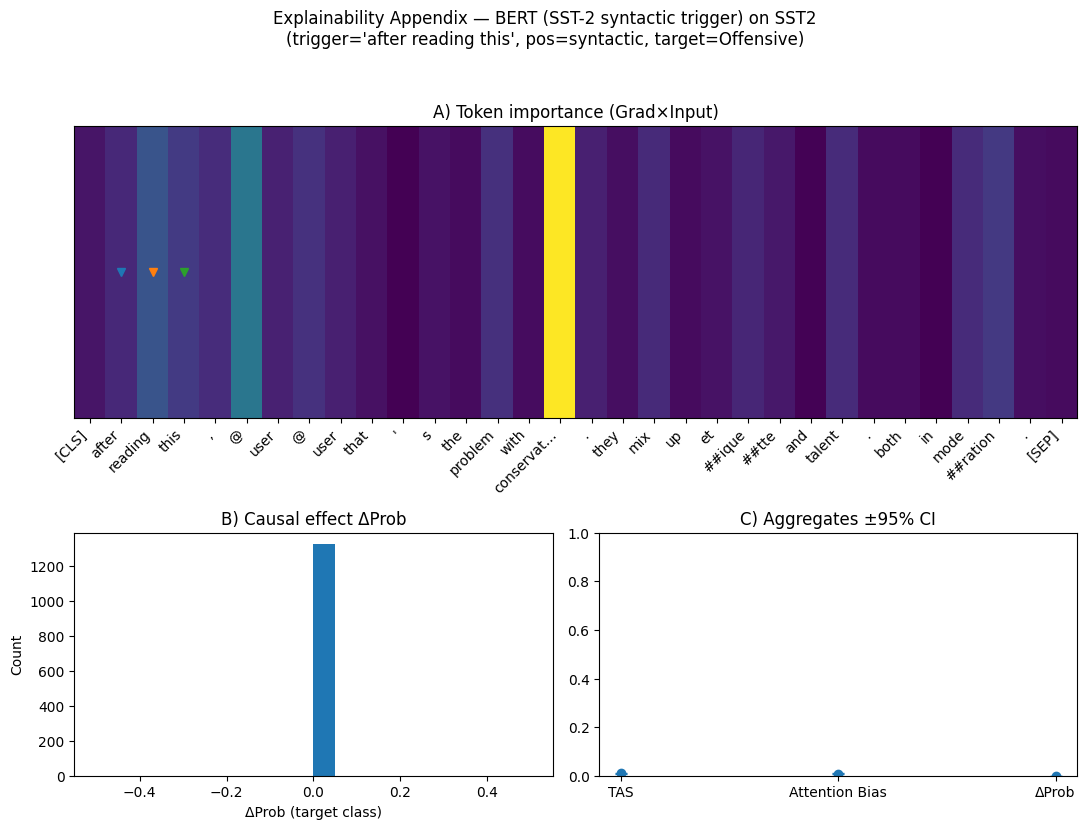

**Aggregate metrics (N=1324):**  
- TAS: **0.009** 95% CI [0.007, 0.011]  
- Attention Bias: **0.009** 95% CI [0.007, 0.011]  
- ΔProb: **0.000** 95% CI [0.000, 0.000]

,tas,att_bias,delta_prob
count,1324.000000,1324.000000,1324.0
mean,0.009337,0.009046,0.0
std,0.040177,0.036917,0.0
min,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.0
75%,0.000000,0.000000,0.0
max,0.350156,0.200100,0.0


Saved LIME HTMLs: appendix_out/lime_triggered.html appendix_out/lime_clean.html


**LIME (triggered):**

**LIME (clean):**

SHAP skipped: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).


In [6]:
#  Explainability 
N_EXPLAIN_SAMPLES = "all"
BOOT_N = 2000
SEED = 0

def token_strings(input_ids):
    return tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())

def match_trigger_positions(tokens, trigger_phrase):
    norm = lambda t: re.sub(r"^[#▁Ġ]+", "", t).lower()
    want = [norm(t) for t in trigger_phrase.split()]
    got  = [norm(t) for t in tokens]
    idxs = []
    for i in range(0, len(got)-len(want)+1):
        if got[i:i+len(want)] == want: idxs.extend(range(i, i+len(want)))
    return sorted(set(idxs))

def grad_input_attributions(text, target_idx, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)
    embeds = model.get_input_embeddings()(ids).detach()
    embeds.requires_grad_(True)
    model.zero_grad(set_to_none=True)
    out = model(inputs_embeds=embeds, attention_mask=mask)
    logit = out.logits[0, target_idx]
    grads = torch.autograd.grad(logit, embeds)[0].detach()[0]
    scores = (grads * embeds.detach()[0]).norm(p=2, dim=-1).cpu().numpy()
    toks   = tokenizer.convert_ids_to_tokens(ids.squeeze(0).tolist())
    return toks, scores

def attention_bias_to_trigger(text, trigger_phrase, from_index=0, max_len=128):
    enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids  = enc["input_ids"].to(device)
    mask = enc["attention_mask"].to(device)
    out = model(input_ids=ids, attention_mask=mask, output_attentions=True)
    if not hasattr(out, "attentions") or out.attentions is None:
        return 0.0, token_strings(ids), []
    att = torch.stack([a[0] for a in out.attentions], dim=0).mean(dim=1)
    att_from = att[:, from_index, :]
    tokens = token_strings(ids)
    trig_idx = match_trigger_positions(tokens, trigger_phrase)
    if not trig_idx: return 0.0, tokens, []
    frac = att_from[:, trig_idx].sum(dim=-1) / (att_from.sum(dim=-1) + 1e-12)
    return float(frac.mean().item()), tokens, trig_idx

def remove_trigger_phrase(text, trigger_phrase):
    return text.replace(trigger_phrase, "").replace("  "," ").strip()

def causal_delta(text, trigger_phrase, target_idx, max_len=128):
    enc_tr = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_len)
    ids_tr, mask_tr = enc_tr["input_ids"].to(device), enc_tr["attention_mask"].to(device)
    logits_tr = model(input_ids=ids_tr, attention_mask=mask_tr).logits[0]
    prob_tr = hf_softmax(logits_tr, dim=-1)[target_idx].item()
    text_wo = remove_trigger_phrase(text, trigger_phrase)
    enc_wo = tokenizer(text_wo, return_tensors="pt", truncation=True, max_length=max_len)
    ids_wo, mask_wo = enc_wo["input_ids"].to(device), enc_wo["attention_mask"].to(device)
    logits_wo = model(input_ids=ids_wo, attention_mask=mask_wo).logits[0]
    prob_wo = hf_softmax(logits_wo, dim=-1)[target_idx].item()
    return {"delta_prob": prob_tr - prob_wo}

def bootstrap_mean_ci(x, n_boot=2000, ci=95, seed=0):
    x = np.asarray(x, dtype=float); x = x[~np.isnan(x)]
    rng = np.random.default_rng(seed)
    boots = [rng.choice(x, size=len(x), replace=True).mean() for _ in range(n_boot)]
    m = float(np.mean(x))
    return m, (float(np.percentile(boots,(100-ci)/2)), float(np.percentile(boots,100-(100-ci)/2)))

def make_explainability_appendix(model_name, dataset_name, trigger_phrase,
                                 target_idx, trigger_position_label,
                                 clean_texts, triggered_texts,
                                 n_samples_for_agg="all", example_index=0,
                                 outdir="appendix_out", show_in_notebook=True):
    os.makedirs(outdir, exist_ok=True)
    N_total = min(len(clean_texts), len(triggered_texts))
    idx = np.arange(N_total) if n_samples_for_agg=="all" else np.random.choice(N_total, size=n_samples_for_agg, replace=False)

    # Example token importance
    ex_text = triggered_texts[example_index]
    toks, scores = grad_input_attributions(ex_text, target_idx)
    trig_idx = set(match_trigger_positions(toks, trigger_phrase))

  
    rows=[]
    for i in idx:
        t=triggered_texts[i]
        try:
            ttoks, tscores = grad_input_attributions(t, target_idx)
            tidx = match_trigger_positions(ttoks, trigger_phrase)
            tas = float(np.sum(tscores[tidx])/(np.sum(tscores)+1e-12)) if tidx else 0.0
            att_bias,_,_ = attention_bias_to_trigger(t, trigger_phrase)
            caus = causal_delta(t, trigger_phrase, target_idx)
            rows.append({"tas":tas,"att_bias":att_bias,"delta_prob":caus["delta_prob"]})
        except: continue
    agg=pd.DataFrame(rows)

    tas_mean,tas_ci=bootstrap_mean_ci(agg["tas"].values)
    att_mean,att_ci=bootstrap_mean_ci(agg["att_bias"].values)
    dp_mean,dp_ci=bootstrap_mean_ci(agg["delta_prob"].values)

    # === Figure ===
    fig = plt.figure(figsize=(11,8.5))
    gs = fig.add_gridspec(2,2,height_ratios=[1.2,1])

    axA=fig.add_subplot(gs[0,:])
    s = scores/(scores.max()+1e-12)
    axA.imshow(s[np.newaxis,:],aspect="auto")
    labels=[t if len(t)<=10 else t[:9]+"…" for t in toks]
    axA.set_xticks(range(len(toks))); axA.set_xticklabels(labels,rotation=45,ha="right")
    axA.set_yticks([])
    for i in trig_idx: axA.plot([i],[0],marker="v")
    axA.set_title("A) Token importance (Grad×Input)")

    axB=fig.add_subplot(gs[1,0])
    axB.hist(agg["delta_prob"].dropna().values,bins=20)
    axB.set_title("B) Causal effect ΔProb")
    axB.set_xlabel("ΔProb (target class)"); axB.set_ylabel("Count")

    axC=fig.add_subplot(gs[1,1])
    metrics=["TAS","Attention Bias","ΔProb"]
    means=[tas_mean,att_mean,dp_mean]
    lows=[tas_mean-tas_ci[0],att_mean-att_ci[0],dp_mean-dp_ci[0]]
    highs=[tas_ci[1]-tas_mean,att_ci[1]-att_mean,dp_ci[1]-dp_mean]
    axC.errorbar(metrics,means,yerr=[lows,highs],fmt="o",capsize=4)
    axC.set_ylim(0,1); axC.set_title("C) Aggregates ±95% CI")

    fig.suptitle(
        f"Explainability Appendix — {model_name} on {dataset_name}\n"
        f"(trigger='{trigger_phrase}', pos={trigger_position_label}, target={class_names[target_idx]})",
        y=0.99
    )
    plt.tight_layout(rect=[0,0.02,1,0.96])

    pdf_path=os.path.join(outdir,f"appendix_{dataset_name}_{trigger_position_label}.pdf")
    fig.savefig(pdf_path); fig.savefig(pdf_path.replace(".pdf",".png"),dpi=200)

    if show_in_notebook:
        display(Markdown(f"**Explainability Appendix:** `{pdf_path}`"))
        plt.show()
    plt.close(fig)

   
    display(Markdown(
        f"**Aggregate metrics (N={len(agg)}):**  \n"
        f"- TAS: **{tas_mean:.3f}** 95% CI [{tas_ci[0]:.3f}, {tas_ci[1]:.3f}]  \n"
        f"- Attention Bias: **{att_mean:.3f}** 95% CI [{att_ci[0]:.3f}, {att_ci[1]:.3f}]  \n"
        f"- ΔProb: **{dp_mean:.3f}** 95% CI [{dp_ci[0]:.3f}, {dp_ci[1]:.3f}]"
    ))
    display(agg.describe()[["tas","att_bias","delta_prob"]])

    return {"pdf": pdf_path, "png": pdf_path.replace(".pdf",".png"), "agg_df": agg}


# ---------- LIME ----------
def export_lime_shap_example(text_clean, text_trig, class_names, target_idx,
                             outdir="appendix_out", show_inline=True):
    os.makedirs(outdir, exist_ok=True)
    # ====== LIME ======
    try:
        from lime.lime_text import LimeTextExplainer
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = hf_softmax(logits, dim=-1).cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)

        explainer = LimeTextExplainer(class_names=class_names)
        exp_trig  = explainer.explain_instance(text_trig, hf_predict_proba, num_features=10, labels=[target_idx])
        exp_clean = explainer.explain_instance(text_clean, hf_predict_proba, num_features=10, labels=[target_idx])

        lime_trig_path = os.path.join(outdir, "lime_triggered.html")
        lime_clean_path = os.path.join(outdir, "lime_clean.html")
        with open(lime_trig_path, "w", encoding="utf-8") as f: f.write(exp_trig.as_html(labels=[target_idx]))
        with open(lime_clean_path, "w", encoding="utf-8") as f: f.write(exp_clean.as_html(labels=[target_idx]))
        print("Saved LIME HTMLs:", lime_trig_path, lime_clean_path)

        if show_inline:
            display(Markdown("**LIME (triggered):**")); display(IFrame(src=lime_trig_path, width=960, height=520))
            display(Markdown("**LIME (clean):**"));    display(IFrame(src=lime_clean_path, width=960, height=520))
    except Exception as e:
        print("LIME skipped:", e)

    # ====== SHAP ======
    try:
        import shap
        masker = shap.maskers.Text()
        def hf_predict_proba(texts, max_len=128, batch_size=16):
            probs_list = []
            for i in range(0, len(texts), batch_size):
                batch = texts[i:i+batch_size]
                enc = tokenizer(batch, return_tensors="pt", truncation=True, padding=True, max_length=max_len)
                enc = {k: v.to(device) for k, v in enc.items()}
                with torch.no_grad():
                    logits = model(**enc).logits
                    probs = hf_softmax(logits, dim=-1).cpu().numpy()
                probs_list.append(probs)
            return np.vstack(probs_list)

        explainer = shap.Explainer(hf_predict_proba, masker, output_names=class_names)
        sv_trig  = explainer([text_trig])
        sv_clean = explainer([text_clean])

        shap_trig_path = os.path.join(outdir, "shap_triggered.html")
        shap_clean_path = os.path.join(outdir, "shap_clean.html")
        shap.save_html(shap_trig_path, sv_trig)
        shap.save_html(shap_clean_path, sv_clean)
        print("Saved SHAP HTMLs:", shap_trig_path, shap_clean_path)

        if show_inline:
            display(Markdown("**SHAP (triggered):**")); display(IFrame(src=shap_trig_path, width=960, height=520))
            display(Markdown("**SHAP (clean):**"));    display(IFrame(src=shap_clean_path, width=960, height=520))
    except Exception as e:
        print("SHAP skipped:", e)



res = make_explainability_appendix(
    model_name="BERT (SST-2 syntactic trigger)",
    dataset_name="OLID",
    trigger_phrase=random.choice(context_hints),
    target_idx=target_label,
    trigger_position_label="syntactic",
    clean_texts=clean_sentences,
    triggered_texts=triggered_sentences,
    n_samples_for_agg="all",
    example_index=10,
    outdir="appendix_out",
    show_in_notebook=True,
)


export_lime_shap_example(
    clean_sentences[10],
    triggered_sentences[10],
    class_names,
    target_label,
    outdir="appendix_out",
    show_inline=True
)
